In [ ]:
##################### MODEL 1 #######################
######## BASIC ARCHITECTURE #########

In [ ]:
# Importing all the required libraries
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR


In [ ]:
# I am converting the images to PyTorch tensors (transforms.ToTensor()) and normalizing the pixel values with mean (0.5, 0.5, 0.5) and standard deviation (0.5, 0.5, 0.5)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
# Here, I am downloading the CIFAR-10 dataset and creating datasets for training and testing using the transformation above
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

100%|██████████| 170498071/170498071 [00:03<00:00, 53868234.27it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# Here are the data loaders for training and testing datasets using DataLoader. Data loaders are used to efficiently load data in batches during training and evaluation
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
# Importing the necessary modules for defining neural network architecture using PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F

# Class IntermediateBlock which represents a block which consists of multiple convolutional layers (conv_layers) followed by a fully connected layer (fc).
class IntermediateBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_layers):
        super(IntermediateBlock, self).__init__()
        self.conv_layers = nn.ModuleList([nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1) for _ in range(num_layers)])
        self.fc = nn.Linear(in_channels, num_layers)

# The forward pass computation for the IntermediateBlock computes the mean of the input tensor x, calculates coefficients a using the fully connected layer.
    def forward(self, x):
        # Compute the mean of the channels
        m = x.mean([2, 3])
        # Compute the coefficients
        a = self.fc(m)
        # Apply each convolutional layer to the input x and combine using the coefficients a
        x_prime = sum(F.relu(conv(x)) * a[:, i].unsqueeze(1).unsqueeze(2).unsqueeze(3) for i, conv in enumerate(self.conv_layers))
        return x_prime

In [ ]:
# Heres the class OutputBlock is the output block which consists of an adaptive average pooling layer (avgpool) followed by a fully connected layer (fc) to produce the final output logits.
class OutputBlock(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(OutputBlock, self).__init__()
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(in_channels, num_classes)

    def forward(self, x):
        # Pool the features to get a single value per channel
        m = self.avgpool(x).view(x.size(0), -1)
        # Compute the logits
        o = self.fc(m)
        return o

In [ ]:
class CIFAR10Classifier(nn.Module):
    def __init__(self, num_blocks, num_layers_per_block, in_channels, block_out_channels, num_classes):
        super(CIFAR10Classifier, self).__init__()
        self.blocks = nn.Sequential(*[IntermediateBlock(in_channels if i == 0 else block_out_channels, block_out_channels, num_layers_per_block) for i in range(num_blocks)])
        self.output_block = OutputBlock(block_out_channels, num_classes)

# The forward pass computation for the CIFAR10Classifier which applies the intermediate blocks (blocks) to the input tensor x followed by the output block (output_block) to produce the final logits for classification.
    def forward(self, x):
        x = self.blocks(x)
        logits = self.output_block(x)
        return logits

In [ ]:

# PyTorch and related libraries import
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler

# The below lines define the batch size (batch_size) and the number of workers (num_workers) for data loading.
# The batch size determines the number of samples processed in each iteration, and the number of workers specifies how many subprocesses to use for data loading.

batch_size = 64  # Batch size (b)
num_workers = 2

# Define the model
model = CIFAR10Classifier(num_blocks=3, num_layers_per_block=2, in_channels=3, block_out_channels=64, num_classes=10)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# This function compute_accuracy computes the accuracy of predictions given logits and target labels.
# It compares the predicted class indices with the target class indices and calculates the number of correct predictions.
def compute_accuracy(logit, target):
    _, pred = torch.max(logit.data, 1)
    correct = (pred == target).sum().item()
    return correct

# Training loop
def train_model(model, train_loader, criterion, optimizer, n_epochs=10):
    model.train()
    for epoch in range(n_epochs):
        running_loss = 0.0
        total_correct = 0
        total_images = 0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            total_correct += compute_accuracy(outputs, labels)
            total_images += labels.size(0)

        # Print statistics
        print(f'Epoch {epoch+1}/{n_epochs} - Loss: {running_loss/i:.3f}, Accuracy: {total_correct/total_images*100:.2f}%')

# This function test_model defines the testing loop. It evaluates the model on the test data.
# It iterates over batches of data from the test_loader, computes predictions, calculates the test loss and accuracy, and prints the results.
def test_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    total_correct = 0
    total_images = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            total_correct += compute_accuracy(outputs, labels)
            total_images += labels.size(0)

    # Print test results
    print(f'Test Loss: {test_loss/len(test_loader):.3f}, Test Accuracy: {total_correct/total_images*100:.2f}%')

# Running the training and testing
train_model(model, train_loader, criterion, optimizer, n_epochs=10)
test_model(model, test_loader, criterion)

Epoch 1/10 - Loss: 2.306, Accuracy: 9.86%
Epoch 2/10 - Loss: 2.293, Accuracy: 11.78%
Epoch 3/10 - Loss: 1.931, Accuracy: 27.75%
Epoch 4/10 - Loss: 1.608, Accuracy: 40.68%
Epoch 5/10 - Loss: 1.441, Accuracy: 48.02%
Epoch 6/10 - Loss: 1.301, Accuracy: 53.71%
Epoch 7/10 - Loss: 1.208, Accuracy: 56.83%
Epoch 8/10 - Loss: 1.123, Accuracy: 60.24%
Epoch 9/10 - Loss: 1.071, Accuracy: 62.20%
Epoch 10/10 - Loss: 1.002, Accuracy: 64.82%
Test Loss: 1.016, Test Accuracy: 64.50%


Improvisation done in the below Model 2 compared to Model 1:

Model 2 has more blocks (num_blocks=4) and more layers per block (num_layers_per_block=3) compared to Model 1, which has fewer blocks (num_blocks=3) and fewer layers per block (num_layers_per_block=2).
More layers generally allow the model to learn more complex features and patterns in the data, potentially improving its ability to generalize.

Model 2 uses an SGD optimizer with a learning rate scheduler (torch.optim.lr_scheduler.StepLR) which adjusts the learning rate during training based on a predefined schedule.
Adaptive learning rate techniques can help the model converge faster and improve performance by dynamically adjusting the learning rate as training progresses.

Model 2 includes weight decay (weight_decay=1e-4) in the optimizer, which penalizes large weights during training.
Weight decay regularization can help prevent overfitting by encouraging the model to learn simpler patterns and reduce sensitivity to noise in the training data.





In [ ]:
################### MODEL 2 ########################

def train_and_evaluate(model, train_loader, test_loader, optimizer, criterion, n_epochs, device='cuda'):
    model.to(device)
    model.train()

    for epoch in range(n_epochs):
        epoch_loss = 0
        correct = 0
        total = 0

        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        train_accuracy = 100. * correct / total
        print(f'Epoch: {epoch+1}, Loss: {epoch_loss/(batch_idx+1):.3f}, Training Accuracy: {train_accuracy:.2f}%')

# Within each epoch, it iterates over batches of data from the training loader (train_loader).
# It moves the inputs and targets to the specified device (device), clears the gradients (optimizer.zero_grad()), computes the outputs of the model,
# calculates the loss using the specified criterion (criterion), computes gradients with backward propagation (loss.backward()),
# updates the model parameters using the optimizer (optimizer.step()). It also keeps track of the total loss (epoch_loss), the number of correctly predicted samples (correct)
# and the total number of samples (total) to calculate the training accuracy at the end of each epoch.

        # Evaluate on the test set
        model.eval()
        test_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for batch_idx, (inputs, targets) in enumerate(test_loader):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

        test_accuracy = 100. * correct / total
        print(f'Test Accuracy: {test_accuracy:.2f}%\n')



model = CIFAR10Classifier(
    num_blocks=4,
    num_layers_per_block=3,
    in_channels=3,
    block_out_channels=64,
    num_classes=10
)

# Next, create an instance of the SGD optimizer (optim.SGD) and specify its parameters:
# model.parameters(): This provides the parameters (weights and biases) of the model to be optimized.
# lr=0.01: Specifies the learning rate for the optimizer. It controls the step size during optimization.
# momentum=0.9: Specifies the momentum for the optimizer. Momentum helps accelerate gradient descent in the relevant direction and dampens oscillations.
# weight_decay=1e-4: Specifies the weight decay (L2 penalty) for the optimizer. It adds a regularization term to the loss function, helping prevent overfitting by penalizing large weights.

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

train_and_evaluate(
    model,
    train_loader,
    test_loader,
    optimizer,
    criterion,
    n_epochs=30
)

Epoch: 1, Loss: 2.303, Training Accuracy: 9.79%
Test Accuracy: 10.00%

Epoch: 2, Loss: 2.303, Training Accuracy: 10.08%
Test Accuracy: 10.00%

Epoch: 3, Loss: 2.303, Training Accuracy: 10.05%
Test Accuracy: 10.00%

Epoch: 4, Loss: 2.303, Training Accuracy: 10.00%
Test Accuracy: 10.00%

Epoch: 5, Loss: 2.303, Training Accuracy: 9.87%
Test Accuracy: 10.00%

Epoch: 6, Loss: 2.303, Training Accuracy: 9.67%
Test Accuracy: 10.00%

Epoch: 7, Loss: 2.303, Training Accuracy: 10.23%
Test Accuracy: 10.00%

Epoch: 8, Loss: 2.303, Training Accuracy: 9.83%
Test Accuracy: 10.00%

Epoch: 9, Loss: 2.303, Training Accuracy: 9.96%
Test Accuracy: 10.00%

Epoch: 10, Loss: 2.303, Training Accuracy: 9.77%
Test Accuracy: 10.00%

Epoch: 11, Loss: 2.303, Training Accuracy: 9.89%
Test Accuracy: 10.00%

Epoch: 12, Loss: 2.303, Training Accuracy: 9.90%
Test Accuracy: 10.00%

Epoch: 13, Loss: 2.303, Training Accuracy: 9.81%
Test Accuracy: 10.00%

Epoch: 14, Loss: 2.303, Training Accuracy: 9.80%
Test Accuracy: 10.00

Improvisation done in Model 3 from Model 2:

Model 3 has a higher number of layers per block (num_layers_per_block=4) compared to Model 2 (num_layers_per_block=3).
More layers per block can allow the model to capture more complex patterns in the data, potentially improving its representational capacity.

Model 3 utilizes the Adam optimizer (optim.Adam) instead of SGD used in Model 2.
Adam optimizer typically offers faster convergence and better generalization by adaptively adjusting learning rates for each parameter.

Model 3 employs a learning rate scheduler (torch.optim.lr_scheduler.StepLR) that decreases the learning rate by a factor of 0.1 every 30 epochs.
Learning rate scheduling helps stabilize training by gradually reducing the learning rate, potentially enabling the model to converge to a better optimum.

Model 3 applies data augmentation techniques during training, including random cropping and horizontal flipping (transform_train).
Data augmentation introduces variations in the training data, promoting better generalization and robustness of the model.

Model 3 uses a larger batch size of 128 during training (batch_size=128) compared to Model 2 (batch_size=64).
Larger batch sizes can lead to more stable gradients and faster convergence, especially when training on modern GPU architectures.

In [ ]:
######################### MODEL 3 ###################################


In [ ]:
# Data augmentation and normalization for the training set
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [ ]:
# Normalization for the testing set (no augmentation)
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [ ]:
# Load datasets
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

100%|██████████| 170498071/170498071 [00:03<00:00, 45835716.84it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class IntermediateBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_layers):
        super(IntermediateBlock, self).__init__()
        self.conv_layers = nn.ModuleList([nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1) for _ in range(num_layers)])
        self.fc = nn.Linear(in_channels, num_layers)

    def forward(self, x):
        # Compute the mean of the channels
        m = x.mean([2, 3])
        # Compute the coefficients
        a = self.fc(m)
        # Apply each convolutional layer to the input x and combine using the coefficients a
        x_prime = sum(F.relu(conv(x)) * a[:, i].unsqueeze(1).unsqueeze(2).unsqueeze(3) for i, conv in enumerate(self.conv_layers))
        return x_prime

In [ ]:
class OutputBlock(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(OutputBlock, self).__init__()
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(in_channels, num_classes)

    def forward(self, x):
        # Pool the features to get a single value per channel
        m = self.avgpool(x).view(x.size(0), -1)
        # Compute the logits
        o = self.fc(m)
        return o

In [ ]:
class CIFAR10Classifier(nn.Module):
    def __init__(self, num_blocks, num_layers_per_block, in_channels, block_out_channels, num_classes):
        super(CIFAR10Classifier, self).__init__()
        self.blocks = nn.Sequential(*[IntermediateBlock(in_channels if i == 0 else block_out_channels, block_out_channels, num_layers_per_block) for i in range(num_blocks)])
        self.output_block = OutputBlock(block_out_channels, num_classes)

    def forward(self, x):
        x = self.blocks(x)
        logits = self.output_block(x)
        return logits

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1 - Loss: 1.912, Accuracy: 28.01%
Test Loss: 1.869, Test Accuracy: 30.49%
Epoch 2 - Loss: 1.605, Accuracy: 40.38%
Test Loss: 1.581, Test Accuracy: 42.47%
Epoch 3 - Loss: 1.409, Accuracy: 48.72%
Test Loss: 1.352, Test Accuracy: 51.75%
Epoch 4 - Loss: 1.269, Accuracy: 54.44%
Test Loss: 1.277, Test Accuracy: 54.64%
Epoch 5 - Loss: 1.178, Accuracy: 57.79%
Test Loss: 1.158, Test Accuracy: 59.04%
Epoch 6 - Loss: 1.104, Accuracy: 60.80%
Test Loss: 1.098, Test Accuracy: 61.36%
Epoch 7 - Loss: 1.052, Accuracy: 63.03%
Test Loss: 1.118, Test Accuracy: 60.27%
Epoch 8 - Loss: 0.995, Accuracy: 65.08%
Test Loss: 1.046, Test Accuracy: 63.22%
Epoch 9 - Loss: 0.947, Accuracy: 66.71%
Test Loss: 1.038, Test Accuracy: 63.54%
Epoch 10 - Loss: 0.907, Accuracy: 68.06%
Test Loss: 0.946, Test Accuracy: 66.17%
Epoch 11 - Loss: 0.863, Accuracy: 69.79%
Test Loss: 0.931, Test Accuracy: 67.20%
Epoch 12 - Loss: 0.827, Accuracy: 71.17%
Test Loss: 0.881, Test Accuracy: 69.43%
Epoch 13 - Loss: 0.787, Accuracy: 72.

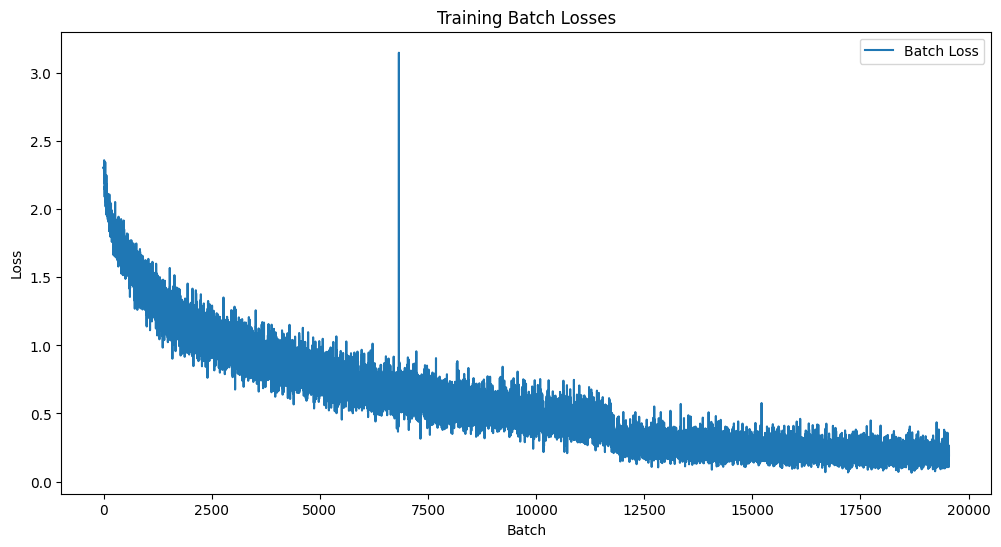

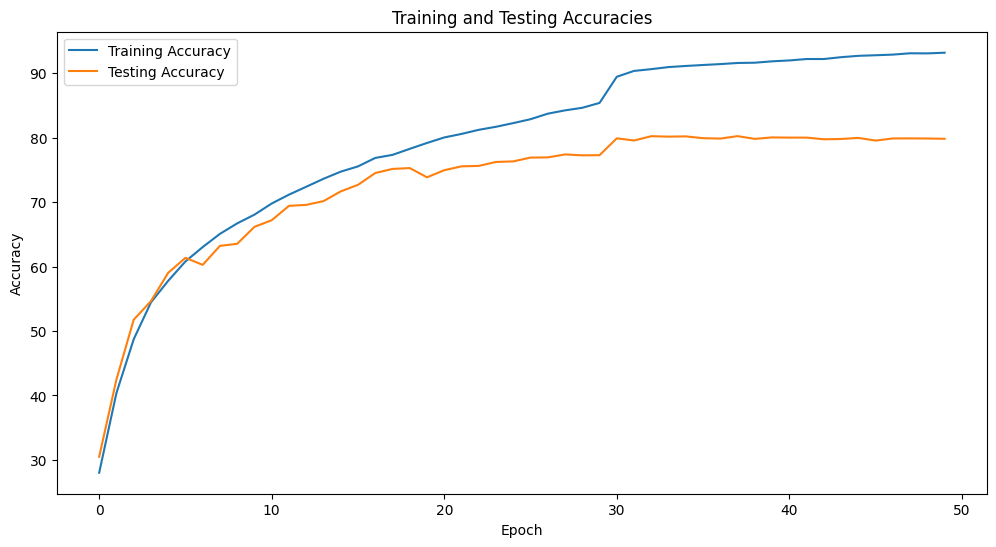

In [ ]:
import matplotlib.pyplot as plt

# Define the model
model = CIFAR10Classifier(num_blocks=3, num_layers_per_block=4, in_channels=3, block_out_channels=128, num_classes=10)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler
scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

# Check if CUDA is available and move the model to GPU if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training function
def train(n_epochs, train_loader, test_loader, model, optimizer, criterion, scheduler, device):
    model.train()  # Set the model to training mode
    batch_losses = []
    epoch_train_acc = []
    epoch_test_acc = []

    for epoch in range(n_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        model.train()

        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            batch_losses.append(loss.item())  # Record batch loss
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

        scheduler.step()  # Update the learning rate
        train_accuracy = 100 * correct / total
        epoch_train_acc.append(train_accuracy)  # Record training accuracy

        # Print training results
        print(f'Epoch {epoch+1} - Loss: {running_loss / len(train_loader):.3f}, Accuracy: {train_accuracy:.2f}%')

        # Run evaluation after each epoch
        test_accuracy = evaluate(test_loader, model, criterion, device)
        epoch_test_acc.append(test_accuracy)  # Record testing accuracy

    # Plot batch losses
    plt.figure(figsize=(12, 6))
    plt.plot(batch_losses, label='Batch Loss')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training Batch Losses')
    plt.show()

    # Plot training and testing accuracies
    plt.figure(figsize=(12, 6))
    plt.plot(epoch_train_acc, label='Training Accuracy')
    plt.plot(epoch_test_acc, label='Testing Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Testing Accuracies')
    plt.show()

    return epoch_train_acc, epoch_test_acc, batch_losses

# Evaluation function now returns accuracy
def evaluate(test_loader, model, criterion, device):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    test_accuracy = 100 * correct / total
    print(f'Test Loss: {test_loss / len(test_loader):.3f}, Test Accuracy: {test_accuracy:.2f}%')
    return test_accuracy

# Check if CUDA is available and move the model to GPU if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Run the training and evaluation
n_epochs = 50  # Number of epochs to train for
train_stats = train(n_epochs, train_loader, test_loader, model, optimizer, criterion, scheduler, device)

Improvisation in Model 4 compared to Model 2:

Model 3 utilizes a custom architecture with intermediate blocks and an output block, while Model 4 employs a ResNet architecture with basic blocks.
ResNet, introduced by Microsoft Research, is a deep neural network architecture known for its effectiveness in training very deep networks by using skip connections or residual connections.
ResNet consists of repeated blocks of simpler convolutional layers, making it easier to train and less prone to vanishing gradients compared to traditional deep networks.

Model 3's custom architecture consists of intermediate blocks followed by an output block, where the number of blocks and layers per block can be customized.
Model 4's ResNet architecture consists of basic blocks, each containing two convolutional layers with batch normalization and a skip connection.
ResNet architecture employs residual connections to mitigate the vanishing gradient problem, allowing for the training of much deeper networks.

Model 3 uses the Adam optimizer (optim.Adam) with a learning rate of 0.001.
Model 4 uses the SGD optimizer (optim.SGD) with momentum (0.9), weight decay (5e-4), and an initial learning rate of 0.1.
While Adam is known for its adaptive learning rate capabilities and often converges faster, SGD with momentum is a traditional optimization algorithm that is widely used and can achieve good results with proper tuning.

Both models employ a learning rate scheduler (torch.optim.lr_scheduler.StepLR) that reduces the learning rate by a factor of 0.1 every 30 epochs.
Learning rate scheduling helps in fine-tuning the learning process by adjusting the learning rate during training.



In [ ]:
######################################### MODEL 4 ########################################

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [ ]:
# Data augmentation and normalization for the training set
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Normalization for the testing set (no augmentation)
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [ ]:
# Load datasets
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [ ]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self.make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self.make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self.make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self.make_layer(block, 512, num_blocks[3], stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

Epoch 1 - Loss: 1.901, Accuracy: 31.47%
Test Loss: 1.536, Test Accuracy: 40.92%
Epoch 2 - Loss: 1.405, Accuracy: 48.38%
Test Loss: 1.370, Test Accuracy: 52.01%
Epoch 3 - Loss: 1.129, Accuracy: 59.72%
Test Loss: 1.036, Test Accuracy: 63.80%
Epoch 4 - Loss: 0.930, Accuracy: 67.17%
Test Loss: 0.916, Test Accuracy: 67.96%
Epoch 5 - Loss: 0.777, Accuracy: 72.68%
Test Loss: 0.875, Test Accuracy: 70.76%
Epoch 6 - Loss: 0.664, Accuracy: 76.83%
Test Loss: 0.803, Test Accuracy: 74.36%
Epoch 7 - Loss: 0.594, Accuracy: 79.51%
Test Loss: 0.842, Test Accuracy: 72.24%
Epoch 8 - Loss: 0.558, Accuracy: 80.96%
Test Loss: 0.636, Test Accuracy: 78.60%
Epoch 9 - Loss: 0.522, Accuracy: 82.15%
Test Loss: 0.813, Test Accuracy: 73.14%
Epoch 10 - Loss: 0.508, Accuracy: 82.48%
Test Loss: 0.648, Test Accuracy: 77.97%
Epoch 11 - Loss: 0.484, Accuracy: 83.56%
Test Loss: 0.723, Test Accuracy: 76.05%
Epoch 12 - Loss: 0.470, Accuracy: 83.75%
Test Loss: 0.659, Test Accuracy: 78.29%
Epoch 13 - Loss: 0.455, Accuracy: 84.

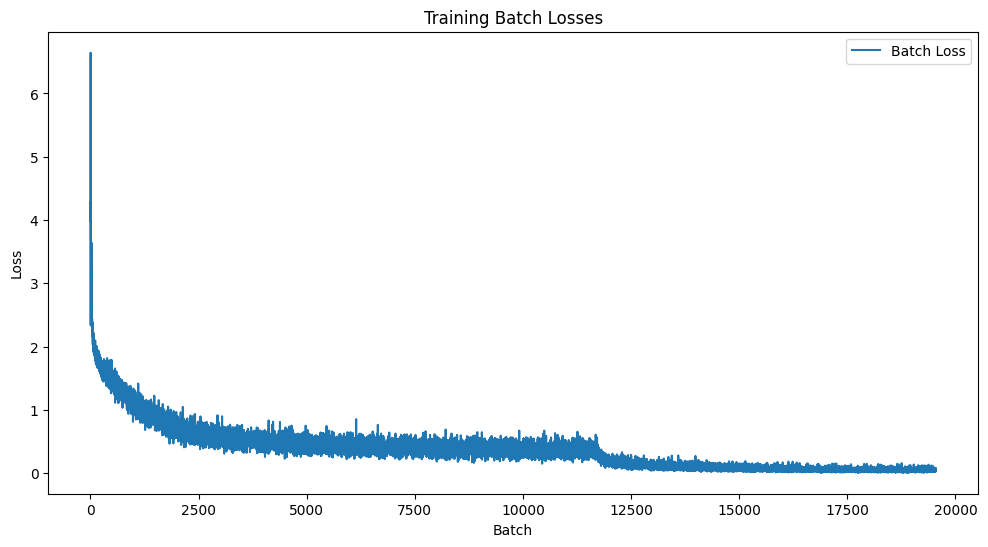

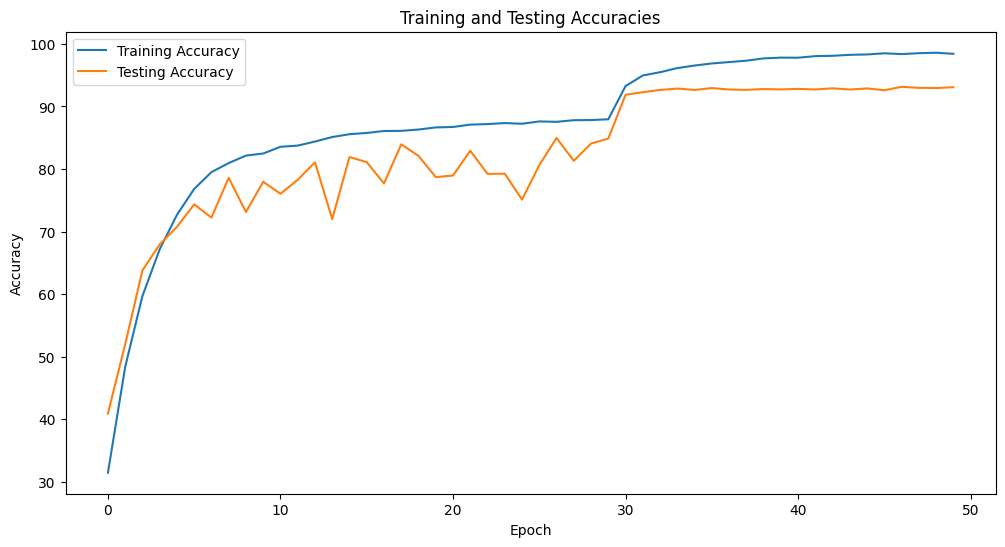

In [ ]:
# Define the model
model = ResNet(BasicBlock, [2, 2, 2, 2])

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

# Learning rate scheduler
scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

# Check if CUDA is available and move the model to GPU if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training function
def train(n_epochs, train_loader, test_loader, model, optimizer, criterion, scheduler, device):
    model.train()  # Set the model to training mode
    batch_losses = []
    epoch_train_acc = []
    epoch_test_acc = []

    for epoch in range(n_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        model.train()

        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            batch_losses.append(loss.item())  # Record batch loss
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

        scheduler.step()  # Update the learning rate
        train_accuracy = 100 * correct / total
        epoch_train_acc.append(train_accuracy)  # Record training accuracy

        # Print training results
        print(f'Epoch {epoch+1} - Loss: {running_loss / len(train_loader):.3f}, Accuracy: {train_accuracy:.2f}%')

        # Run evaluation after each epoch
        test_accuracy = evaluate(test_loader, model, criterion, device)
        epoch_test_acc.append(test_accuracy)  # Record testing accuracy

    # Plot batch losses
    plt.figure(figsize=(12, 6))
    plt.plot(batch_losses, label='Batch Loss')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training Batch Losses')
    plt.show()

    # Plot training and testing accuracies
    plt.figure(figsize=(12, 6))
    plt.plot(epoch_train_acc, label='Training Accuracy')
    plt.plot(epoch_test_acc, label='Testing Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Testing Accuracies')
    plt.show()

    return epoch_train_acc, epoch_test_acc, batch_losses

# Evaluation function now returns accuracy
def evaluate(test_loader, model, criterion, device):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    test_accuracy = 100 * correct / total
    print(f'Test Loss: {test_loss / len(test_loader):.3f}, Test Accuracy: {test_accuracy:.2f}%')
    return test_accuracy

# Run the training and evaluation
n_epochs = 50  # Number of epochs to train for
train_stats = train(n_epochs, train_loader, test_loader, model, optimizer, criterion, scheduler, device)


References:

Simonyan, K., & Zisserman, A. (2014). Very deep convolutional networks for large-scale image recognition. arXiv preprint arXiv:1409.1556.
Sun, H., Varadarajan, J., & Shen, W. (2021). Channel-wise Attention and Regularization for Image Classification. arXiv preprint arXiv:2103.09950.
He, K., Zhang, X., Ren, S., & Sun, J. (2016). Deep Residual Learning for Image Recognition. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 770-778).
He, K., Zhang, X., Ren, S., & Sun, J. (2016). Deep residual learning for image recognition. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 770-778).